Import libraries for carrying out UMM analysis.

In [4]:
import pandas as pd
import geopandas as gpd
import momepy as mm
import matplotlib.pyplot as plt
import osmnx as ox
import libpysal
from tqdm import tqdm
from momepy import limit_range
import numpy as np
import scipy as sp
import mapclassify
import mapclassify.classifiers as classifiers
from libpysal.weights import KNN
from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import AgglomerativeClustering 
from sklearn import metrics
import seaborn as sns
import matplotlib.ticker as mticker
from scipy.cluster import hierarchy

In [5]:
import warnings
warnings.filterwarnings("ignore")

# STEP 1

UMM works better with official datasets of buildings and streets. However, it also produces good results with OpenStreetMap (OSM). Here, we show a pipeline which uses the latter.

### get buildings from OSM

In [6]:
#establish a center point. In this example, we select a part of Glasgow (UK) which includes our campus, the Central Station and other important landmarks.
center_point = (55.862441267743826, -4.24512097737466)

In [7]:
tags = {"building": True}

In [8]:
# use osmnx to get buildings footprints for the area of interest
gdf1 = ox.geometries_from_point(center_point, tags, dist=1000)
buildings = ox.project_gdf(gdf1)

<Axes: >

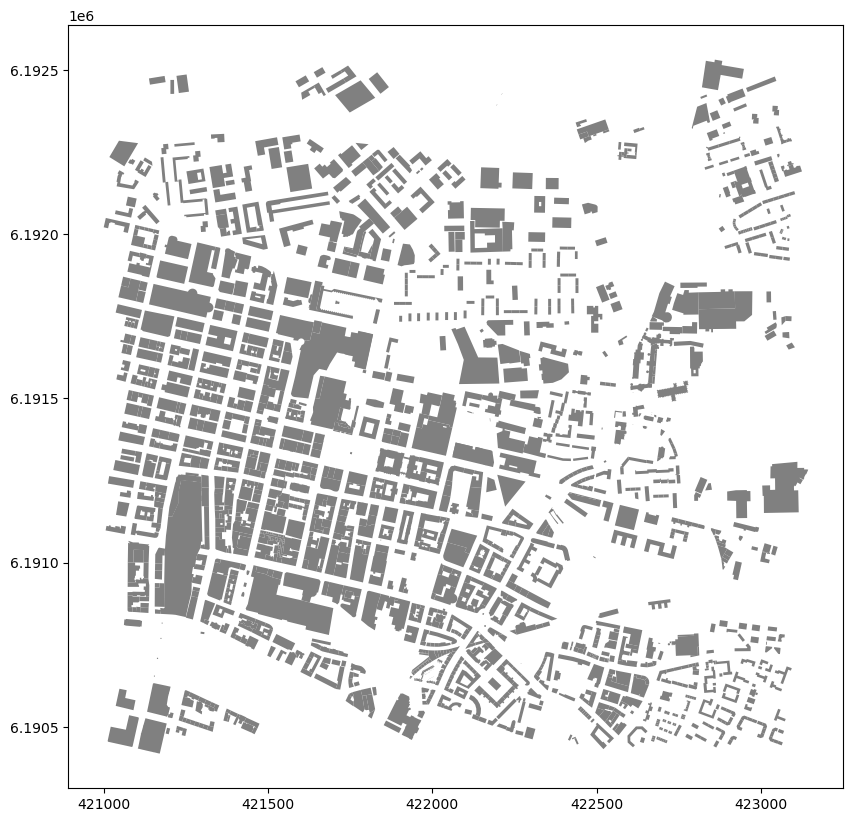

In [9]:
# let's see what we extracted from OSM
buildings.plot(figsize=(10,10), color='grey')

In [10]:
# sometimes OSM data include elements which are not polygons so we filter them out
buildings.geom_type.value_counts()

Polygon         1757
Point              3
MultiPolygon       1
Name: count, dtype: int64

In [11]:
buildings = buildings[buildings.geom_type == 'Polygon']

In [12]:
# some further cleaning
buildings.geometry = buildings.buffer(0)

c:\Users\reube\anaconda3\envs\nbprocessor\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [13]:
buildings.is_valid.all()

True

In [14]:
# remove empty geometries (if present)
buildings = buildings[~buildings.is_empty]

In [15]:
# reset index
buildings = buildings.reset_index(drop=True)

In [16]:
# add ids
buildings["uID"] = range(len(buildings))
buildings = buildings[['uID','geometry']]

### get streets from OSM

In [17]:
# let's get streets now
G = ox.graph_from_point(center_point, dist=1000, network_type='drive') #selecting drive to remove paths in parks, smaller access lanes, etc

In [18]:
G_proj = ox.projection.project_graph(G)

In [19]:
# we will have to transform the graph from networkx to geopandas
nodes, streets = mm.nx_to_gdf(G_proj, points=True, lines=True)

C:\Users\reube\AppData\Local\Temp\ipykernel_22744\395142585.py:2: UserWarning: Approach is not set. Defaulting to 'primal'.
  nodes, streets = mm.nx_to_gdf(G_proj, points=True, lines=True)


In [20]:
# add ids
streets["nID"] = range(len(streets))
streets = streets[['nID','geometry']]

<Axes: >

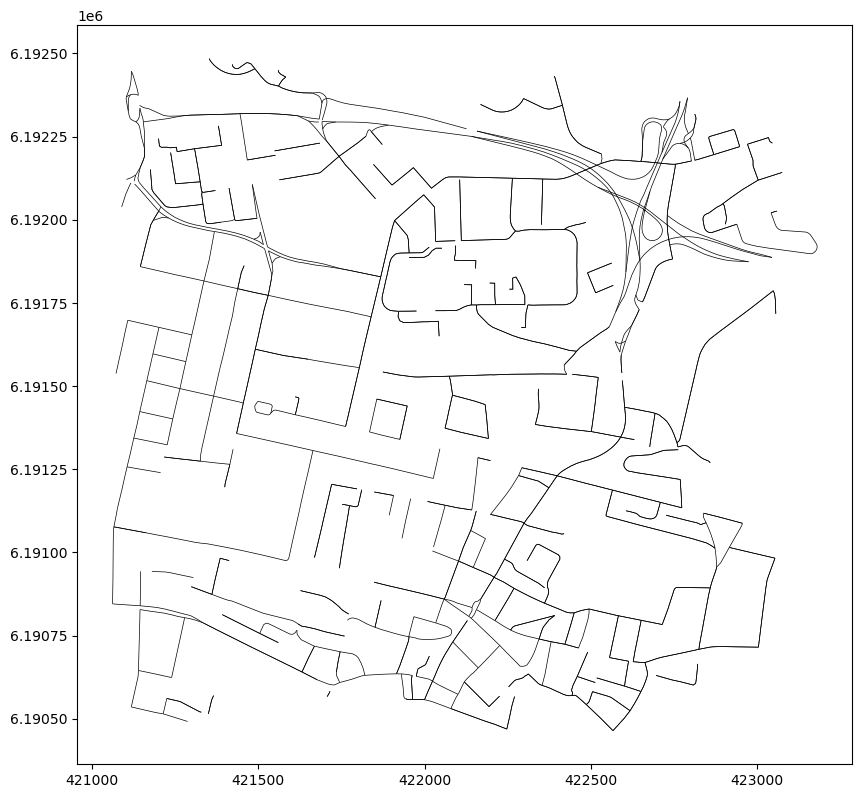

In [21]:
# let's see what we extracted from OSM
streets.plot(figsize=(10, 10), color='k', lw=0.5)

## Generating tessellation cells

In [22]:
# create an area to limit the creation of the tessellation cells

In [23]:
hull = buildings.unary_union.convex_hull
hull = gpd.GeoDataFrame(index=[0], geometry=[hull])
hull = hull.buffer(10) #this is a small buffer (10m) to avoid potenital issues with the computation of characters

<Axes: >

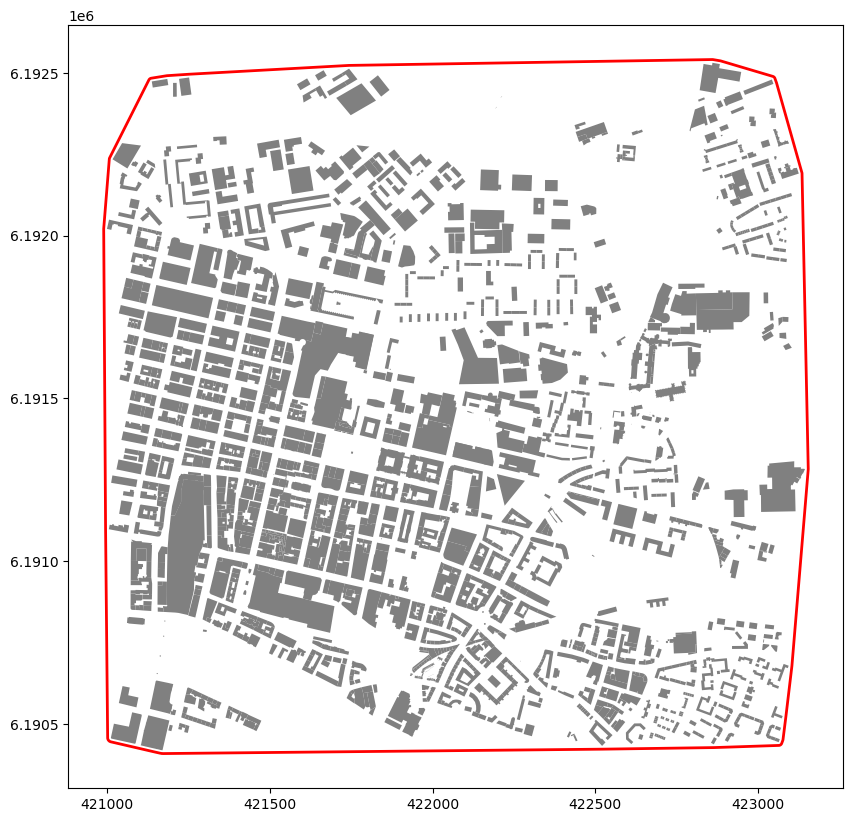

In [24]:
# let's see the extent of hull
f, ax = plt.subplots(1, figsize=(10, 10))
buildings.plot(ax=ax, color='grey', zorder=1)
hull.boundary.plot(ax=ax, color='r', lw=2)

In [25]:
tess = mm.Tessellation(buildings, 'uID', hull)

Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...


C:\Users\reube\AppData\Local\Temp\ipykernel_22744\2004469971.py:1: UserWarning: Tessellation does not fully match buildings. 3 element(s) collapsed during generation - unique_id: {742, 1518, 1519}.
  tess = mm.Tessellation(buildings, 'uID', hull)
C:\Users\reube\AppData\Local\Temp\ipykernel_22744\2004469971.py:1: UserWarning: Tessellation contains MultiPolygon elements. Initial objects should  be edited. `unique_id` of affected elements: [1321, 731, 739, 2, 13, 437, 744, 12, 1342, 743, 465, 1349, 1334, 642, 1735, 1298, 423, 1297, 1260, 1327, 1361, 1293, 1723, 66, 701, 68].
  tess = mm.Tessellation(buildings, 'uID', hull)


In [26]:
tess = tess.tessellation

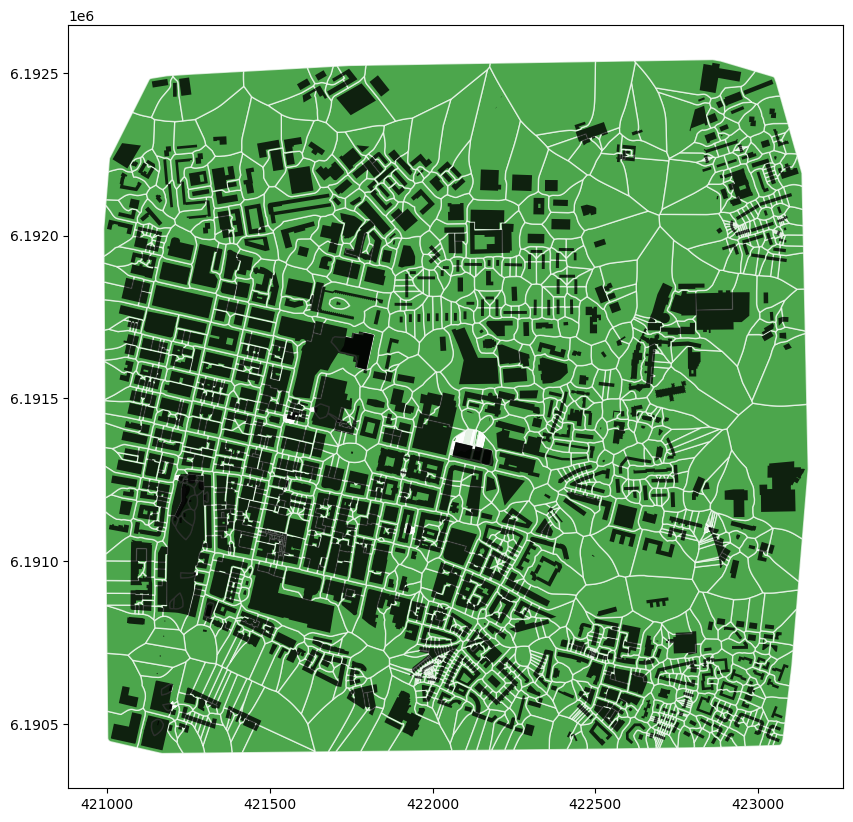

In [27]:
# plot the tessellation cells you have just created
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(ax=ax, facecolor="black", alpha=0.8, zorder=10)
tess.plot(ax=ax, facecolor="green", edgecolor='white', lw=1, alpha=0.7, zorder=5)
plt.show()

## Create tessellation based blocks

In [28]:
blocks0 = mm.Blocks(tess, streets, buildings, id_name='bID', unique_id='uID')

c:\Users\reube\anaconda3\envs\nbprocessor\Lib\site-packages\momepy\elements.py:619: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  weights = libpysal.weights.Queen.from_dataframe(cut, silence_warnings=True)


In [29]:
blocks = blocks0.blocks

In [30]:
buildings['bID'] = blocks0.buildings_id
tess['bID'] = blocks0.tessellation_id

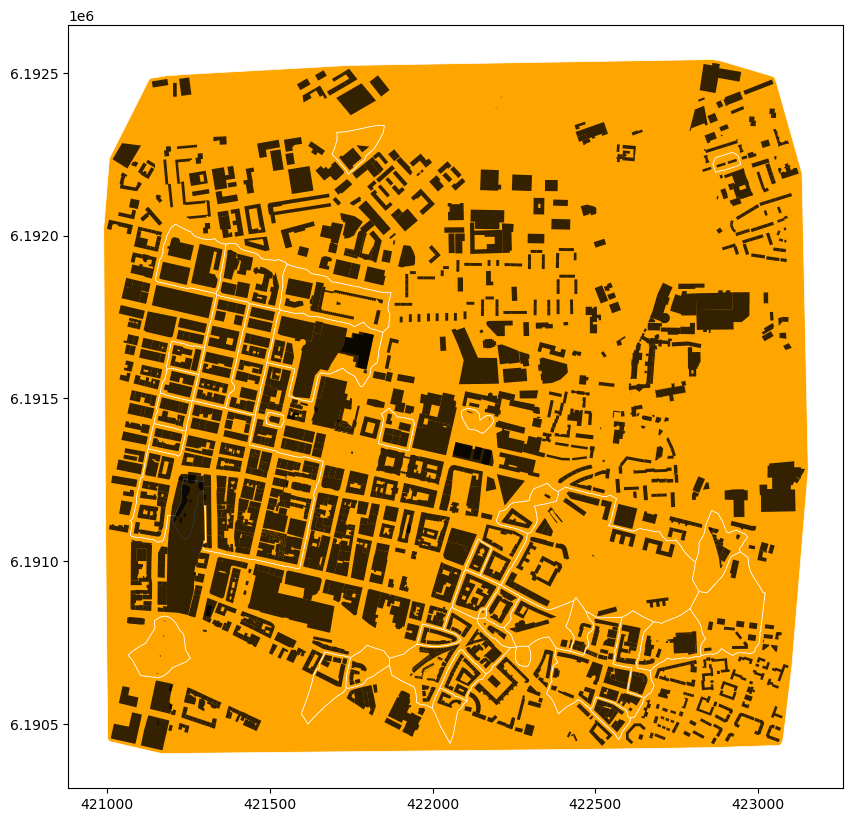

In [31]:
# plot the blocks you have just created
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(ax=ax, color="black", alpha=0.8, zorder=10)
blocks.plot(ax=ax, color='orange', edgecolor='white', lw=0.5, zorder=8)
plt.show()

## Link streets

In [32]:
buildings['nID'] = mm.get_network_id(buildings, streets, 'nID')  
tess = tess.merge(buildings[['uID', 'nID']], on='uID', how='left')

Snapping: 100%|██████████| 1757/1757 [00:01<00:00, 1462.92it/s]
C:\Users\reube\AppData\Local\Temp\ipykernel_22744\187280293.py:1: UserWarning: Some objects were not attached to the network. Set larger `min_size``. 37 affected elements.
  buildings['nID'] = mm.get_network_id(buildings, streets, 'nID')


# STEP 2

## Compute primary characters

In [33]:
buildings['sdbAre'] = mm.Area(buildings).series
buildings['ssbCCo'] = mm.CircularCompactness(buildings, 'sdbAre').series
buildings['ssbCor'] = mm.Corners(buildings).series
buildings['ssbSqu'] = mm.Squareness(buildings).series
buildings['ssbElo'] = mm.Elongation(buildings).series
buildings['mtbSWR'] = mm.SharedWallsRatio(buildings).series

100%|██████████| 1757/1757 [00:00<00:00, 4944.16it/s]
c:\Users\reube\anaconda3\envs\nbprocessor\Lib\site-packages\momepy\distribution.py:137: FutureWarning: The `query_bulk()` method is deprecated and will be removed in GeoPandas 1.0. You can use the `query()` method instead.
  inp, res = gdf.sindex.query_bulk(gdf.geometry, predicate="intersects")


In [34]:
cencon = mm.CentroidCorners(buildings)
buildings['ssbCCM'] = cencon.mean
buildings['ssbCCD'] = cencon.std

100%|██████████| 1757/1757 [00:00<00:00, 1915.71it/s]


In [35]:
buildings['stbOri'] = mm.Orientation(buildings).series
tess['stcOri'] = mm.Orientation(tess).series

buildings['stbCeA'] = mm.CellAlignment(buildings, tess, 'stbOri', 'stcOri', 'uID', 'uID').series

100%|██████████| 1754/1754 [00:00<00:00, 19514.76it/s]


In [36]:
tess['sdcAre'] = mm.Area(tess).series
tess['sicCAR'] = mm.AreaRatio(tess, buildings, 'sdcAre', 'sdbAre', 'uID').series
tess['sdcLAL'] = mm.LongestAxisLength(tess).series
tess['sdcAre'] = mm.Area(tess).series
tess['sscCCo'] = mm.CircularCompactness(tess, 'sdcAre').series

In [37]:
# some characters include the surrounding local context. This is why we need to build a spatial matrix
queen_1 = libpysal.weights.contiguity.Queen.from_dataframe(tess, ids="uID")
 
buildings["mtbAli"] = mm.Alignment(buildings, queen_1, "uID", "stbOri").series
buildings["mtbNDi"] = mm.NeighborDistance(buildings, queen_1, "uID").series
tess["mtcWNe"] = mm.Neighbors(tess, queen_1, "uID", weighted=True).series
tess["mdcAre"] = mm.CoveredArea(tess, queen_1, "uID").series

100%|██████████| 1754/1754 [00:00<00:00, 3043.77it/s]


In [40]:
blg_q1 = libpysal.weights.contiguity.Queen.from_dataframe(buildings)
 
buildings["ldbPWL"] = mm.PerimeterWall(buildings, blg_q1).series
 
blocks["ldkAre"] = mm.Area(blocks).series
blocks["lskCCo"] = mm.CircularCompactness(blocks, "ldkAre").series
blocks["ltkOri"] = mm.Orientation(blocks).series
 
blo_q1 = libpysal.weights.contiguity.Queen.from_dataframe(blocks, ids="bID")
 
blocks["ltkWNB"] = mm.Neighbors(blocks, blo_q1, "bID", weighted=True).series
blocks["likWBB"] = mm.Count(blocks, buildings, "bID", "bID", weighted=True).series

C:\Users\reube\AppData\Local\Temp\ipykernel_22744\3358940322.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  blg_q1 = libpysal.weights.contiguity.Queen.from_dataframe(buildings)
c:\Users\reube\anaconda3\envs\nbprocessor\Lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 734 disconnected components.
 There are 462 islands with ids: 1, 5, 6, 7, 8, 14, 16, 17, 18, 21, 22, 29, 33, 35, 37, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 55, 56, 58, 59, 62, 70, 71, 72, 77, 81, 83, 84, 86, 90, 102, 105, 106, 108, 109, 110, 112, 113, 116, 119, 120, 121, 122, 123, 125, 127, 129, 130, 131, 138, 141, 142, 143, 145, 146, 158, 159, 160, 161, 163, 164, 165, 166, 167, 168, 169, 170, 176, 183, 195, 203, 210, 215, 218, 241, 247, 249, 310, 332, 334, 341, 345, 355, 371, 372, 374, 381, 445, 446, 447, 448, 450, 452, 453, 4

In [41]:
queen3 = mm.sw_high(k=3, weights=queen_1)
queen1 = queen_1
blg_queen = blg_q1

buildings['ltbIBD'] = mm.MeanInterbuildingDistance(buildings, queen1, 'uID', queen3).series
buildings['ltcBuA'] = mm.BuildingAdjacency(buildings, queen3, 'uID', blg_queen).series

Computing mean interbuilding distances...


Calculating adjacency: 100%|██████████| 1757/1757 [00:00<00:00, 109805.73it/s]


In [42]:
tess['ltcWRB'] = mm.BlocksCount(tess, 'bID', queen3, 'uID').series

100%|██████████| 1754/1754 [00:02<00:00, 676.07it/s]


In [52]:
streets["sdsLen"] = mm.Perimeter(streets).series
 
streets["sssLin"] = mm.Linearity(streets).series
streets["sdsAre"] = mm.Reached(streets, tess, "nID", "nID", mode="sum", values="sdcAre").series
streets["sisBpM"] = mm.Count(streets, buildings, "nID", "nID", weighted=True).series

AttributeError: 'NoneType' object has no attribute 'geom_type'

In [ ]:
str_q1 = libpysal.weights.contiguity.Queen.from_dataframe(streets)
 
streets["misRea"] = mm.Reached(streets, tess, "nID", "nID", spatial_weights=str_q1, mode="count").series
streets["mdsAre"] = mm.Reached(streets, tess, "nID", "nID", spatial_weights=str_q1,mode="sum").series

In [ ]:
graph = mm.gdf_to_nx(streets)
 
print("node degree")
graph = mm.node_degree(graph)
 
print("subgraph")
graph = mm.subgraph(
    graph,
    radius=5,
    meshedness=True,
    cds_length=False,
    mode="sum",
    degree="degree",
    length="mm_len",
    mean_node_degree=False,
    proportion={0: True, 3: True, 4: True},
    cyclomatic=False,
    edge_node_ratio=False,
    gamma=False,
    local_closeness=True,
    closeness_weight="mm_len",
)
print("cds length")
graph = mm.cds_length(graph, radius=3, name="ldsCDL")
 
print("clustering")
graph = mm.clustering(graph, name="xcnSCl")
 
print("mean_node_dist")
graph = mm.mean_node_dist(graph, name="mtdMDi")
 
nodes, edges, sw = mm.nx_to_gdf(graph, spatial_weights=True)
 
edges_w3 = mm.sw_high(k=3, gdf=edges)
edges["ldsMSL"] = mm.SegmentsLength(edges, spatial_weights=edges_w3, mean=True).series
 
edges["ldsRea"] = mm.Reached(edges, tess, "nID", "nID", spatial_weights=edges_w3).series
edges["ldsRea"] = mm.Reached(edges, tess, "nID", "nID", spatial_weights=edges_w3, mode="sum", values="sdcAre").series
 
nodes_w5 = mm.sw_high(k=5, weights=sw)
nodes["lddNDe"] = mm.NodeDensity(nodes, edges, nodes_w5).series
nodes["linWID"] = mm.NodeDensity(nodes, edges, nodes_w5, weighted=True, node_degree="degree").series
 
buildings["nodeID"] = mm.get_node_id(buildings, nodes, edges, "nodeID", "nID")
tess = tess.merge(buildings[["uID", "nodeID"]], on="uID", how="left")
 
nodes_w3 = mm.sw_high(k=3, weights=sw)
 
nodes["lddRea"] = mm.Reached(nodes, tess, "nodeID", "nodeID", nodes_w3).series
nodes["lddARe"] = mm.Reached(nodes, tess, "nodeID", "nodeID", nodes_w3, mode="sum", values="sdcAre").series
 
nodes["sddAre"] = mm.Reached(nodes, tess, "nodeID", "nodeID", mode="sum", values="sdcAre").series
nodes["midRea"] = mm.Reached(nodes, tess, "nodeID", "nodeID", spatial_weights=sw).series
nodes["midAre"] = mm.Reached(nodes, tess, "nodeID", "nodeID", spatial_weights=sw, mode="sum", values="sdcAre").series
 
nodes.rename(
    columns={
        "degree": "mtdDeg",
        "meshedness": "lcdMes",
        "local_closeness": "lcnClo",
        "proportion_3": "linP3W",
        "proportion_4": "linP4W",
        "proportion_0": "linPDE",
    }, inplace=True
)

In [51]:
merged = tess.merge(buildings.drop(columns=['nID', 'bID', 'nodeID', 'geometry']), on='uID')
merged = merged.merge(blocks.drop(columns='geometry'), on='bID', how='left')
merged = merged.merge(edges.drop(columns='geometry'), on='nID', how='left')
merged = merged.merge(nodes.drop(columns='geometry'), on='nodeID', how='left')

KeyError: "['nodeID'] not found in axis"

In [55]:
primary = tess.drop(columns=['nID', 'bID', 'geometry'])

# STEP 3

## Compute contextual characters

In [56]:
# this is a function to compute a measure of diversity (Theil index)
def theil(y):
    y = np.array(y)
    n = len(y)
    plus = y + np.finfo('float').tiny * (y == 0)  # can't have 0 values
    yt = plus.sum(axis=0)
    s = plus / (yt * 1.0)
    lns = np.log(n * s)
    slns = s * lns
    t = sum(slns)
    return t

In [57]:
# lets make a copy of the primary
gdf = primary.copy()

In [58]:
# To be sure, we fill empty cells with 0s
gdf = gdf.fillna(0)

In [59]:
# We round the values not to have issues in the computation
gdf = gdf.round(6)

In [60]:
# Set uID as index
gdf = gdf.set_index('uID')

In [61]:
means = {}
ranges = {}
theils = {}

for ch in gdf.columns[1:]:
    means[ch] = []
    ranges[ch] = []
    theils[ch] = []

In [62]:
spatial_weights = queen3

In [65]:
for i in tqdm(gdf.index, total=len(gdf)):
    neighbours = spatial_weights.neighbors[i].copy()
    neighbours.append(i)
    
    for ch in gdf.columns[1:]:
        values_list = gdf.loc[neighbours][ch]
        idec = mm.limit_range(values_list.tolist(), rng=(10, 90))
        iquar = mm.limit_range(values_list.tolist(), rng=(25, 75))
        
        means[ch].append(np.mean(iquar))
        ranges[ch].append(sp.stats.iqr(values_list, rng=(25, 75)))
        theils[ch].append(theil(idec))

for ch in gdf.columns[1:]:
    gdf[ch + '_meanIQ3'] = means[ch]
    gdf[ch + '_rangeIQ3'] = ranges[ch]
    gdf[ch + '_theilID3'] = theils[ch]

100%|██████████| 1754/1754 [00:13<00:00, 128.69it/s]


In [66]:
# we select only the contextual
sel = [c for c in gdf.columns if '_' in c]

In [67]:
cont = gdf[sel] 

# STEP 4

## Perform AHC to cluster the contextual characters

In [ ]:
# Standardise the contextual characters
cont_std = StandardScaler().fit_transform(cont)
cont_std = pd.DataFrame(cont_std, columns=cont.columns)

In [ ]:
# Build spatial matrix. We tried different methods and KNN seems the best so far.
n=3
w = KNN.from_dataframe(tess, k=n)

In [ ]:
# Test different number of clusters/urban types (between 2 and 11)
cont_std_ = cont_std.copy()
K = range(2,11) 
s = {}

In [ ]:
%%time
for k in K: 
    s[k] = []
    np.random.seed(123456) #for reproducibility
    model = AgglomerativeClustering(linkage='ward', connectivity=w.sparse, n_clusters=k)
    y = model.fit(cont_std)
    cont_std_['AHC_k'+ str(k)] = y.labels_
    print('silhouette at k=' + str(k) + ': ' + str(metrics.silhouette_score(cont_std, y.labels_, metric='euclidean')))
    s[k].append(metrics.silhouette_score(cont_std, y.labels_, metric='euclidean'))

In [ ]:
# Create the silhouette diagram  
vals = []
clus = []

for c, v in s.items():
    vals += v
    clus += [c]

In [ ]:
silhouettes = pd.DataFrame({'n_cluster': clus, 'silhouette': vals})

In [ ]:
# Plot the silhouette diagram. The best solution is usually a peak before a sudden drop. We would go with 6 in this case.
fig, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(x="n_cluster", y="silhouette", data=silhouettes)
plt.ticklabel_format(style='plain')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.show()

## Plot maps of urban types and dendrogram

In [ ]:
# rejoin geometries to the dataframe to be able to map results
cont_std_ = cont_std_.join(tess[['geometry']])
cont_std_ = gpd.GeoDataFrame(cont_std_, geometry=cont_std_['geometry'])

In [ ]:
f, ax = plt.subplots(1, figsize=(10, 10))
streets.plot(ax=ax, edgecolor="white", lw=1, alpha=0.7, zorder=5)
buildings.plot(ax=ax, color='white', alpha=0.7, zorder=10)
cont_std_.plot(column='AHC_k6', categorical=True, legend=True, linewidth=0, ax=ax, cmap='tab20', zorder=0)
ax.set_axis_off()
plt.axis('equal')
plt.show()

In [ ]:
# join urban types to the dataframe to build the dendrogram
cont_std = cont_std.join(cont_std_[['AHC_k6']])

In [ ]:
group = cont_std.groupby('AHC_k6').mean()
Z = hierarchy.linkage(group, 'ward')
plt.figure(figsize=(10, 10))
dn = hierarchy.dendrogram(Z, labels=group.index)
plt.show()